In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data as tdata
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as tfms
from hw_4 import *
from model_s8 import *
import model_s8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_data = np.load(f'data/rgbs.npy', allow_pickle=True)
train_labels = np.load(f'data/labels.npy', allow_pickle=True)

In [3]:
# tr = torch.from_numpy(train_data)
# (tr[0]).transpose
# train_data.shape
# tr_2 = np.append(train_data, train_data, axis=0)
# tr_2.shape
# train_labels.shape

In [4]:
class Dataset(tdata.Dataset):
    def __init__(self, rgbs, labels, transform=None):
        super().__init__()
        self.rgbs = rgbs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.rgbs.shape[0]

    def __getitem__(self, i):
        if self.transform is not None:
            print("here")
            return (
                np.asarray((self.transform(self.rgbs[i]))).astype('f4') / 255,
                np.asarray(tfms.Compose([tfms.ToPILImage(), tfms.RandomHorizontalFlip(p=1), tfms.ToTensor()])(self.labels[i]).numpy()).astype('i8')
            )

        return (
            np.asarray(self.rgbs[i]).astype('f4').transpose((2, 0, 1)) / 255,
            np.asarray(self.labels[i]).astype('i8')
            )
    
mean = 0
std = 1

train_ds = Dataset(rgbs=train_data, labels=train_labels, transform=tfms.Compose([tfms.ToTensor(), tfms.Normalize(mean, std)]))
train_ds[0][0].shape, train_data[0].shape, train_ds[0][1].shape


here
here


((3, 512, 800), (512, 800, 3), (1, 512, 800))

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = tfms.Compose([tfms.ToTensor(), tfms.Normalize(mean, std)])

train_ds = Dataset(train_data, train_labels, transform=train_transform)
# tr_set[0].shape
# (train_transform(train_data[0])).shape


(512, 800, 3)
(512, 800)


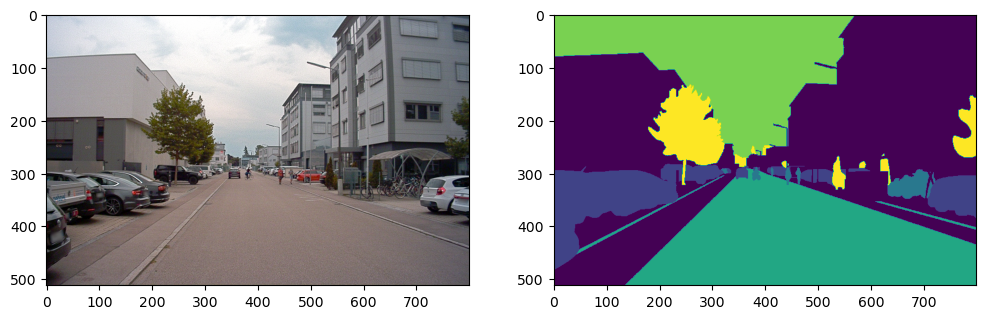

In [6]:
transflip_labels = tfms.Compose([tfms.ToPILImage(), tfms.RandomHorizontalFlip(p=1), tfms.ToTensor()])

fig = plt.figure(figsize=(12, 6))
columns = 2
rows = 1
for i in range(1, columns*rows +1 - 1):
    img = transflip_labels(train_data[i]).numpy().transpose(1, 2, 0)
    print(train_data[i].shape)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

columns = 2
rows = 1

for i in range(2, columns*rows +1):
    img = transflip_labels(train_labels[i - 1]).squeeze(0).numpy()
    print(train_labels[i - 1].shape)
    # img = train_labels[i - 1]

    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()




In [9]:
BATCH_SIZE = 2
train_dataloader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
len(train_dataloader)
for i in train_dataloader:
    print(i[0].shape)
    print(i[1].shape)
    break

here
here
torch.Size([2, 3, 512, 800])
torch.Size([2, 1, 512, 800])


In [75]:
target = torch.randint(0, 10, (10,))
# target = torch.ones(10)
one_hot = torch.nn.functional.one_hot(torch.tensor(train_labels[0]), num_classes=6)
# one_hot = torch.nn.functional.one_hot(torch.tensor(target))
# one_hot
# target.scatter_(1)

RuntimeError: one_hot is only applicable to index tensor.

In [10]:
# device = get_device_mps()
device = torch.device("cpu")
print(device)
encoder = tv.models.vgg16_bn(weights=tv.models.VGG16_BN_Weights.IMAGENET1K_V1).features
model = UnetFromPretrained(encoder=encoder, num_classes=6)
# model.load_state_dict(torch.load('weights_my_res_net.pts'))
model = model.to(device)

cpu


In [4]:
# label_classes = np.array([0, 1, 2, 3, 4, 5])
# classes_occurence = np.array([308165131, 108482485, 4596037, 315958602, 259602639, 284014306])
# # classes_weights = classes_occurence / np.sum(classes_occurence)
# # classes_weights = torch.tensor(classes_weights, dtype=float)

# # classes, occur = numpy.unique(arr, return_counts=True)
# class_weights = np.sum(classes_occurence) / ((label_classes.shape) * classes_occurence)
# class_weights



classes, occur = np.unique(train_labels, return_counts=True)
class_weights = occur.sum()/(occur)

classes, occur, class_weights
# classes_weights = torch.tensor([0.2406, 0.0847, 0.0036, 0.2467, 0.2027, 0.2217], dtype=torch.float32)

# loss_fn = nn.CrossEntropyLoss(weight=classes_weights, reduction="mean").to(device)
# opt = torch.optim.Adam(nn.Sequential(*model.decoder_layers, *model.trans_convs).parameters(), lr=1e-3, weight_decay=1e-5)
# opt = SGD(model.parameters(), lr=0.1, )
# opt = torch.optim.SGD(model.parameters(), lr=1.0e-3, momentum=0.9)
# list(tv.models.vgg16_bn(weights=tv.models.VGG16_BN_Weights.IMAGENET1K_V1).features.parameters())
# list(nn.Sequential(*model.decoder_layers).parameters())


# (array([0, 1, 2, 3, 4, 5], dtype=uint8),
#  array([308165131, 108482485,   4596037, 315958602, 259602639, 284014306]),
#  array([ 0.69271259,  1.96778187, 46.44650743,  0.67562606,  0.82229467,
#          0.7516166 ]))

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([308165131, 108482485,   4596037, 315958602, 259602639, 284014306]),
 array([  4.15627555,  11.80669119, 278.67904458,   4.05375638,
          4.93376803,   4.50969959]))

In [31]:
def train_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    loss_sum = 0
    for idx, batch in enumerate(train_loader):
        data, labels = batch[0].to(device), batch[1].to(device)
        # print(type(batch), len(batch))

        # print(batch)
        print(idx)

        output = model(data)
        loss = loss_fn(output, labels) / 4
        loss.backward()

        if idx % 2 == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        loss_sum += loss.item()

        print("step_DONE")

        if (idx + 1) % 10 == 0:
            print(loss.item())
            break

        if idx == 200: 
            break
        
    loss = loss_sum / (idx+1)
    return model, loss

In [32]:
epoch = 1
for i in range(epoch):
    print(f"epoch {i + 1}/{epoch}")
    _, loss = train_epoch(model, train_loader=train_dataloader, loss_fn=loss_fn, optimizer=opt, device=device)
    print(f"\rTrain loss: {loss:.04f}\r", end="")

epoch 1/1
0
step_DONE
1
step_DONE
2
step_DONE
3
step_DONE
4
step_DONE
5
step_DONE
6
step_DONE
7
step_DONE
8
step_DONE
9
step_DONE
0.2582535445690155


In [85]:
unet = UnetFromPretrained(tv.models.vgg16().features, 6)
# ten_to_unet = torch.rand(1, 3, 512, 800, dtype=torch.float32)
# for elem in train_dataloader:
#     ten_to_unet = elem[0]
#     print(ten_to_unet.shape)
#     arr = unet(ten_to_unet)
#     break

print(arr)

tensor([[[[9.0917e-01, 3.8587e-01, 6.8162e-02,  ..., 5.6206e-01,
           6.8500e-01, 4.3373e-01],
          [9.9994e-01, 1.0974e+00, 1.5563e-01,  ..., 1.5576e-01,
           1.1307e+00, 5.3997e-01],
          [1.3122e+00, 0.0000e+00, 1.6073e-01,  ..., 1.0000e+00,
           7.4965e-01, 5.7495e-01],
          ...,
          [5.2765e-01, 3.9248e-01, 4.4877e-01,  ..., 8.4398e-01,
           0.0000e+00, 8.9851e-01],
          [3.6349e-01, 8.7580e-01, 1.0978e+00,  ..., 0.0000e+00,
           1.2612e+00, 7.4886e-01],
          [2.4357e-01, 1.8119e-01, 1.0647e+00,  ..., 6.0666e-01,
           2.6389e-01, 0.0000e+00]],

         [[5.2247e-01, 1.0433e+00, 7.3104e-01,  ..., 6.1235e-01,
           7.9103e-01, 0.0000e+00],
          [7.0406e-01, 4.8692e-01, 5.5443e-01,  ..., 0.0000e+00,
           6.1980e-01, 5.4216e-01],
          [7.2202e-01, 5.5223e-01, 0.0000e+00,  ..., 7.1459e-01,
           4.4614e-01, 0.0000e+00],
          ...,
          [1.2812e+00, 0.0000e+00, 4.2606e-01,  ..., 2.5616

In [8]:
# save_model(model, "best_model.pth")
arr.reshape(arr.shape[0] // 2, 2)

tensor([[0.0000, 0.0000],
        [0.0000, 0.1398],
        [0.0000, 0.0000],
        ...,
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000]], grad_fn=<ReshapeAliasBackward0>)

In [35]:
model.state_dict().keys()

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.1.weight', 'encoder.1.bias', 'encoder.1.running_mean', 'encoder.1.running_var', 'encoder.1.num_batches_tracked', 'encoder.3.weight', 'encoder.3.bias', 'encoder.4.weight', 'encoder.4.bias', 'encoder.4.running_mean', 'encoder.4.running_var', 'encoder.4.num_batches_tracked', 'encoder.7.weight', 'encoder.7.bias', 'encoder.8.weight', 'encoder.8.bias', 'encoder.8.running_mean', 'encoder.8.running_var', 'encoder.8.num_batches_tracked', 'encoder.10.weight', 'encoder.10.bias', 'encoder.11.weight', 'encoder.11.bias', 'encoder.11.running_mean', 'encoder.11.running_var', 'encoder.11.num_batches_tracked', 'encoder.14.weight', 'encoder.14.bias', 'encoder.15.weight', 'encoder.15.bias', 'encoder.15.running_mean', 'encoder.15.running_var', 'encoder.15.num_batches_tracked', 'encoder.17.weight', 'encoder.17.bias', 'encoder.18.weight', 'encoder.18.bias', 'encoder.18.running_mean', 'encoder.18.running_var', 'encoder.18.num_batches_tracked', 'encode

In [59]:
import time as time

In [61]:
tm = time.localtime()
loc_time = (tm.tm_mday, tm.tm_hour, tm.tm_min)
loc_time

(27, 22, 43)

In [62]:
print(f';aa;a{loc_time}')

;aa;a(27, 22, 43)


In [30]:
import torch
import torch.nn as nn

# Cross-Entropy Loss

# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)

optimizer = torch.optim.Adam([input], lr=1e-3, weight_decay=1e-6)

print('input: ', input)
print('target: ', target)


for i in range(1000):
    cross_entropy_loss = nn.CrossEntropyLoss()
    output = cross_entropy_loss(input, target)
    output.backward()
    optimizer.step()
    optimizer.zero_grad()

print('input: ', input)
print('target: ', target)
print('output: ', output)

input:  tensor([[-2.3648, -2.3648, -2.3648,  9.4915, -2.3648],
        [-2.3693, -2.3693, -2.3693, -2.3693,  9.4850],
        [-2.3646,  9.4915, -2.3646, -2.3646, -2.3646]], requires_grad=True)
target:  tensor([3, 4, 1])
input:  tensor([[-2.3648, -2.3648, -2.3648,  9.4915, -2.3648],
        [-2.3693, -2.3693, -2.3693, -2.3693,  9.4850],
        [-2.3646,  9.4917, -2.3646, -2.3646, -2.3646]], requires_grad=True)
target:  tensor([3, 4, 1])
output:  tensor(2.8411e-05, grad_fn=<NllLossBackward0>)


In [71]:
import torch
import torch.nn as nn

# Cross-Entropy Loss

input = torch.randn(3, 4, 4, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
target = torch.tensor([[0, 1, 1, 2], [0, 0, 0, 0], [0, 1, 1, 2], [2, 2, 2, 2]], dtype=torch.float32)
target = torch.stack([target, target, target])

optimizer = torch.optim.Adam([input], lr=1e-3, weight_decay=1e-6)

print('input:[0] ', input)
print('target: ', target)


for i in range(20000):
    cross_entropy_loss = nn.CrossEntropyLoss()
    output = cross_entropy_loss(input, target)
    output.backward()
    optimizer.step()
    optimizer.zero_grad()

print('input[0]: ', input[0])
print('target: ', target)
print('output: ', output)

input:[0]  tensor([[[-0.1102,  0.7652,  1.4863, -1.3153],
         [-0.3163,  0.4810, -2.2332,  0.4626],
         [ 0.7742,  0.2953, -1.1262, -0.0509],
         [ 2.4142,  0.8601, -0.9924, -1.4963]],

        [[-1.1946,  1.1306, -0.8399, -0.9617],
         [-0.3712, -1.5038, -0.5791, -1.4343],
         [-0.4942, -1.6595, -1.1753, -0.6557],
         [-0.0128,  0.3238,  0.8255, -0.2450]],

        [[-0.3199,  0.1050,  0.1380,  0.5101],
         [-0.3014, -1.4773,  0.5852, -0.3538],
         [-1.3689,  0.9008,  1.0442, -0.3705],
         [ 1.2927,  0.0534,  0.5684, -0.1712]]], requires_grad=True)
target:  tensor([[[0., 1., 1., 2.],
         [0., 0., 0., 0.],
         [0., 1., 1., 2.],
         [2., 2., 2., 2.]],

        [[0., 1., 1., 2.],
         [0., 0., 0., 0.],
         [0., 1., 1., 2.],
         [2., 2., 2., 2.]],

        [[0., 1., 1., 2.],
         [0., 0., 0., 0.],
         [0., 1., 1., 2.],
         [2., 2., 2., 2.]]])
input[0]:  tensor([[-2.9915,  3.4608,  0.7528,  4.0454],
   

In [73]:
input[2]

tensor([[-3.4744,  1.8658,  3.4315,  3.5650],
        [-3.4772, -7.4809, -5.7739, -6.3505],
        [-3.3848,  1.8658,  3.4313,  3.5650],
        [ 7.4700,  2.5590,  4.1246,  3.5650]], grad_fn=<SelectBackward0>)

In [22]:
# model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))
model, enc_name = model_s8.load_model()

/opt/homebrew/Caskroom/miniforge/base/envs/vir_mamba/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/vir_mamba/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(512, 800)
(512, 800)


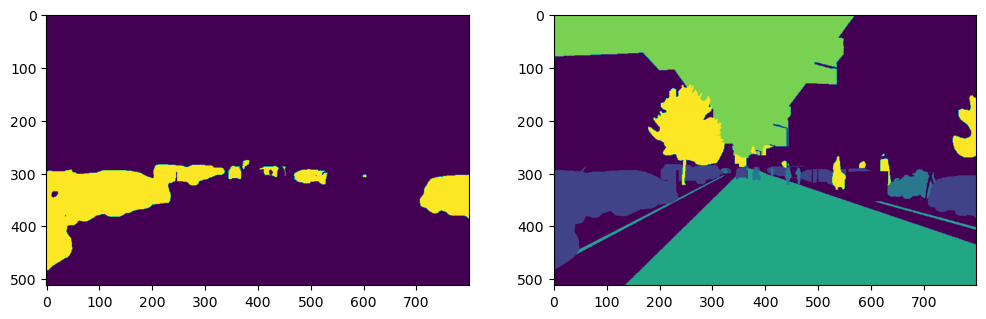

In [40]:
transflip_labels = tfms.Compose([tfms.ToPILImage(), tfms.RandomHorizontalFlip(p=1), tfms.ToTensor()])
with torch.no_grad():
    fig = plt.figure(figsize=(12, 6))
    columns = 2
    rows = 1
    for i in range(1, columns*rows +1 - 1):
        img = model(transflip_labels(train_data[i]).unsqueeze(0)).squeeze(0).detach().numpy()
        # img = img.max(axis=0)
        img = img[1] >= img.max(axis=0)
        # img.max(axis=1).T.transpose(1, 0, 2)
        print(img.shape)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)

    columns = 2
    rows = 1

    for i in range(2, columns*rows +1):
        img = transflip_labels(train_labels[i - 1]).squeeze(0).numpy()
        print(train_labels[i - 1].shape)
        # img = train_labels[i - 1]

        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

In [28]:
train_data[0].shape

(512, 800, 3)